In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Activation
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Resizing , Rescaling
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
! unzip "/content/NNDL2Data.zip"

# Preprocessing + Data AUgmentation

In [3]:
datadir = '/content/NNDL2Data'
categories= ['AD','MCI']
dataa=[]
img_size=128
for category in categories:
  path=os.path.join(datadir,category)
  class_num =categories.index(category) # 0 as AD, 1 as MCI in our classification
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    resized_array = cv2.resize(img_array, (img_size, img_size))
    dataa.append([resized_array, class_num])
print('Number of records before augmentation:',len(dataa))
MCI_1= sum(np.array([item[1] for item in dataa])) #Freq of the class MCI before data augmentation
AD_1=len(dataa) - MCI_1  #Freq of the class AD

Number of records before augmentation: 1654


In [4]:
#Augmentation:
b3=[]
for i in range(len(dataa)):
  a=dataa[i][0]
  b=dataa[i][1]

  datagen = ImageDataGenerator()
  resized_array= np.expand_dims(a, axis=0)
  resized_array= np.expand_dims(resized_array, axis=-1)
  aug_iter= datagen.flow(resized_array, batch_size=1)
  image =next(aug_iter)[0].astype('uint8')
  b3.append([image, b])

  datagen = ImageDataGenerator( horizontal_flip=True )
  resized_array= np.expand_dims(a, axis=0)
  resized_array= np.expand_dims(resized_array, axis=-1)
  aug_iter= datagen.flow(resized_array, batch_size=1)
  image =next(aug_iter)[0].astype('uint8')
  b3.append([image, b])

  datagen= ImageDataGenerator( shear_range=0.2)
  resized_array= np.expand_dims(a, axis=0)
  resized_array= np.expand_dims(resized_array, axis=-1)
  aug_iter = datagen.flow(resized_array, batch_size=1)
  image =next(aug_iter)[0].astype('uint8')
  b3.append([image, b])

  datagen = ImageDataGenerator( width_shift_range=0.1)
  resized_array= np.expand_dims(a, axis=0)
  resized_array= np.expand_dims(resized_array, axis=-1)
  aug_iter = datagen.flow(resized_array, batch_size=1)
  image = next(aug_iter)[0].astype('uint8')
  b3.append([image, b])

  datagen = ImageDataGenerator( rotation_range=15)
  resized_array= np.expand_dims(a, axis=0)
  resized_array= np.expand_dims(resized_array, axis=-1)
  aug_iter = datagen.flow(resized_array, batch_size=1)
  image = next(aug_iter)[0].astype('uint8')
  b3.append([image, b])

  datagen = ImageDataGenerator( zoom_range=0.2)
  resized_array= np.expand_dims(a, axis=0)
  resized_array= np.expand_dims(resized_array, axis=-1)
  aug_iter = datagen.flow(resized_array, batch_size=1)
  image = next(aug_iter)[0].astype('uint8')
  b3.append([image, b])


MCI_2= sum(np.array([item[1] for item in b3]))  #Freq of the class MCI after data augmentation
AD_2=len(b3) - MCI_2                            #Freq of the class AD after data augmentation

print('Number of records before augmentation:',len(dataa))
print('Number of records after augmentation:',len(b3))

Number of records before augmentation: 1654
Number of records after augmentation: 9924


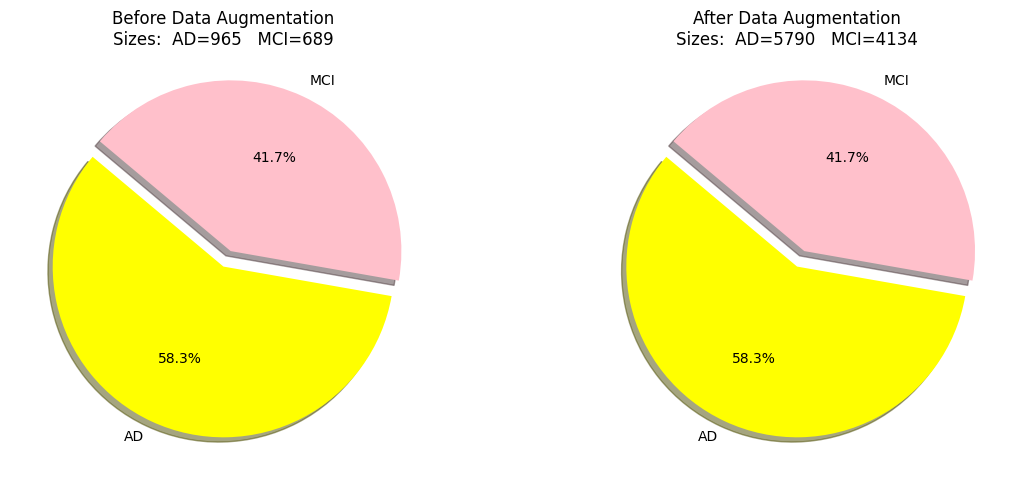

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
labels = ['AD','MCI']
colors = ['yellow', 'pink']
explode = (0, 0.1)
sizes = [AD_1,MCI_1]
ax1.pie([AD_1,MCI_1] , explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140,colors=colors)
ax1.set_title('Before Data Augmentation\nSizes:  AD={}   MCI={}'.format(AD_1,MCI_1))

ax2.pie([AD_2,MCI_2] , explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140,colors=colors)
ax2.set_title('After Data Augmentation\nSizes:  AD={}   MCI={}'.format(AD_2,MCI_2))
plt.tight_layout()
plt.show()

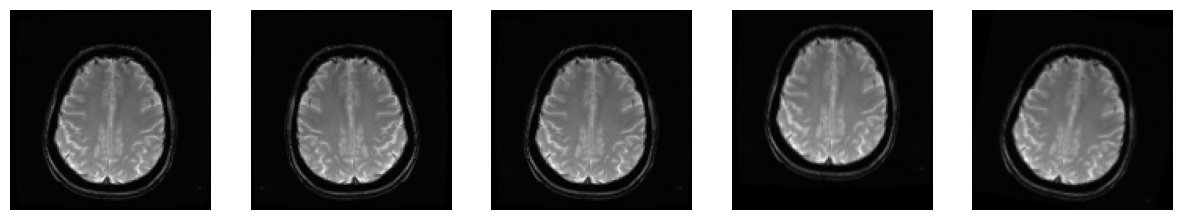

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
  image=b3[i+6][0]
  ax[i].imshow(image,cmap='gray')
  ax[i].axis('off')

In [5]:
X=np.array([item[0] for item in b3])
y=np.array([item[1] for item in b3])

# CNN

In [ ]:
num_samples,height,width,ch= X.shape
X_reshaped=X.reshape((num_samples, height * width))
scaler =StandardScaler()
scaler.fit(X_reshaped)
X_normalized = scaler.transform(X_reshaped)
X_normalized_reshaped = X_normalized.reshape((-1,img_size, img_size,1))
y_one_hot =to_categorical(y, num_classes=len(categories))

X_train, X_test, y_train, y_test = train_test_split(X_normalized_reshaped, y_one_hot, test_size=0.05, random_state=2,shuffle=True,stratify=y)

proposed_model2 = tf.keras.Sequential([
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128),
    Dense(64),
    Dense(2),
    Activation('softmax')])

learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)
proposed_model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_proposed_model2=proposed_model2.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.1 )

Epoch 1/20
133/133 [==============================] - 12s 68ms/step - loss: 588.2776 - accuracy: 0.6248 - val_loss: 18.5739 - val_accuracy: 0.4305
Epoch 2/20
133/133 [==============================] - 9s 66ms/step - loss: 0.9175 - accuracy: 0.7313 - val_loss: 1.7654 - val_accuracy: 0.5440
Epoch 3/20
133/133 [==============================] - 9s 66ms/step - loss: 1.0305 - accuracy: 0.7359 - val_loss: 0.5587 - val_accuracy: 0.7550
Epoch 4/20
133/133 [==============================] - 9s 65ms/step - loss: 0.7129 - accuracy: 0.7558 - val_loss: 0.6581 - val_accuracy: 0.7784
Epoch 5/20
133/133 [==============================] - 9s 65ms/step - loss: 0.5012 - accuracy: 0.7817 - val_loss: 0.5065 - val_accuracy: 0.7487
Epoch 6/20
133/133 [==============================] - 9s 65ms/step - loss: 0.4534 - accuracy: 0.8009 - val_loss: 0.4493 - val_accuracy: 0.7890
Epoch 7/20
133/133 [==============================] - 8s 64ms/step - loss: 0.4550 - accuracy: 0.8107 - val_loss: 0.4693 - val_accuracy: 0.

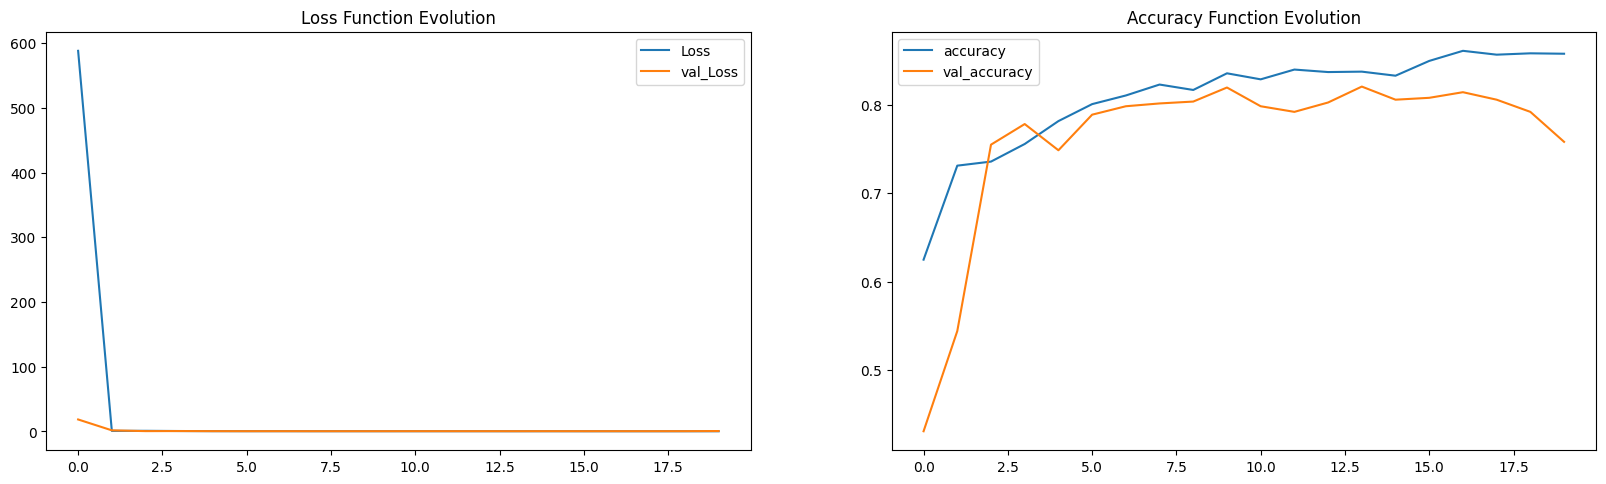

In [ ]:
plt.figure(figsize=(20,25))
plt.subplot(4,2,1)
plt.plot(history_proposed_model2.history['loss'], label='Loss')
plt.plot(history_proposed_model2.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.subplot(4,2,2)
plt.plot(history_proposed_model2.history['accuracy'], label='accuracy')
plt.plot(history_proposed_model2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [ ]:
num_samples,height,width,ch= X.shape
X_reshaped=X.reshape((num_samples, height * width))
scaler =StandardScaler()
scaler.fit(X_reshaped)
X_normalized = scaler.transform(X_reshaped)
X_normalized_reshaped = X_normalized.reshape((-1,img_size, img_size,1))
y_one_hot =to_categorical(y, num_classes=len(categories))

X_train, X_test, y_train, y_test = train_test_split(X_normalized_reshaped, y_one_hot, test_size=0.05, random_state=2,shuffle=True,stratify=y)

proposed_model = tf.keras.Sequential([
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128),
    Dense(64),
    Dense(2),
    Activation('softmax')])

learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)
proposed_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_proposed_model=proposed_model.fit(X_train,y_train,batch_size=64, epochs=25,validation_split=0.1 )

Epoch 1/25
133/133 [==============================] - 12s 68ms/step - loss: 468.8227 - accuracy: 0.6469 - val_loss: 2.7904 - val_accuracy: 0.6660
Epoch 2/25
133/133 [==============================] - 9s 66ms/step - loss: 0.8191 - accuracy: 0.7372 - val_loss: 0.8007 - val_accuracy: 0.7550
Epoch 3/25
133/133 [==============================] - 9s 66ms/step - loss: 0.6154 - accuracy: 0.7599 - val_loss: 0.6446 - val_accuracy: 0.7338
Epoch 4/25
133/133 [==============================] - 9s 66ms/step - loss: 0.5751 - accuracy: 0.7719 - val_loss: 0.5391 - val_accuracy: 0.7487
Epoch 5/25
133/133 [==============================] - 9s 65ms/step - loss: 0.7540 - accuracy: 0.7645 - val_loss: 0.5127 - val_accuracy: 0.7762
Epoch 6/25
133/133 [==============================] - 9s 64ms/step - loss: 0.4937 - accuracy: 0.7961 - val_loss: 0.5124 - val_accuracy: 0.7646
Epoch 7/25
133/133 [==============================] - 9s 64ms/step - loss: 1.2402 - accuracy: 0.7735 - val_loss: 3.8277 - val_accuracy: 0.7

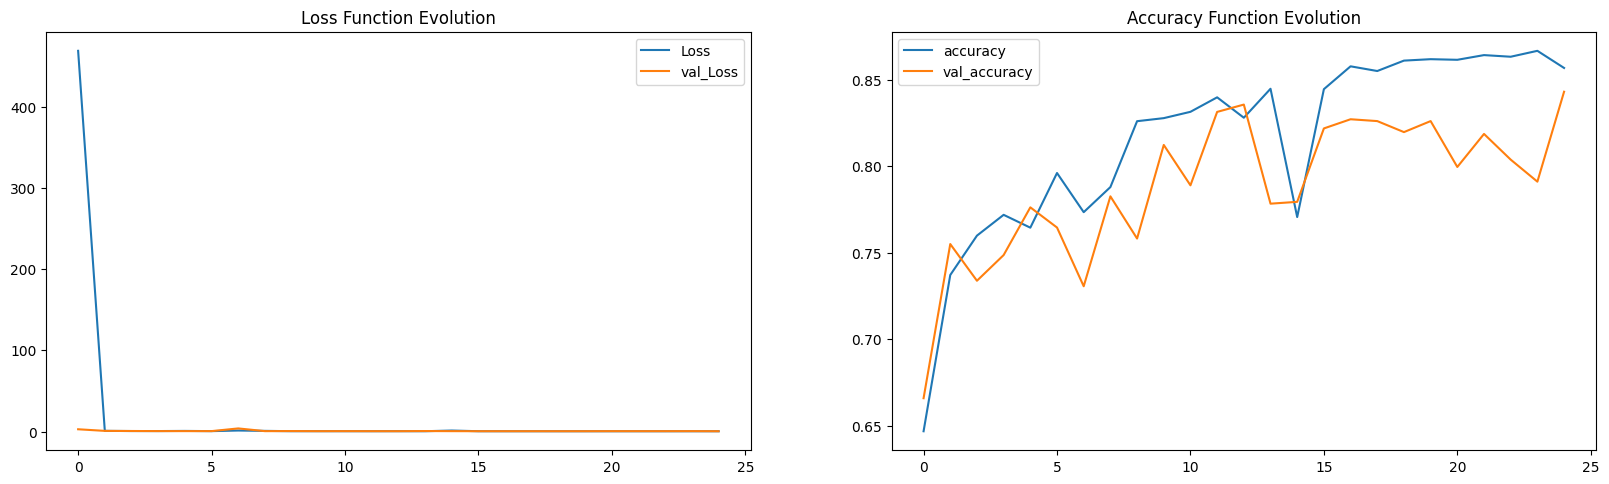

In [ ]:
plt.figure(figsize=(20,25))
plt.subplot(4,2,1)
plt.plot(history_proposed_model.history['loss'], label='Loss')
plt.plot(history_proposed_model.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.subplot(4,2,2)
plt.plot(history_proposed_model.history['accuracy'], label='accuracy')
plt.plot(history_proposed_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [12]:
y_true=np.argmax(y_test,axis=1)
y_pred = proposed_model.predict([X_test])
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(testt, y_pred)
print(conf_mat)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred)
print("Precision:", precision)
recall = recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = f1_score(y_true, y_pred)
print("F1 score:", f1)

[[266  24]
 [ 64 143]]
Accuracy: 0.8229376257545271
Precision: 0.8562874251497006
Recall: 0.6908212560386473
F1 score: 0.7647058823529411


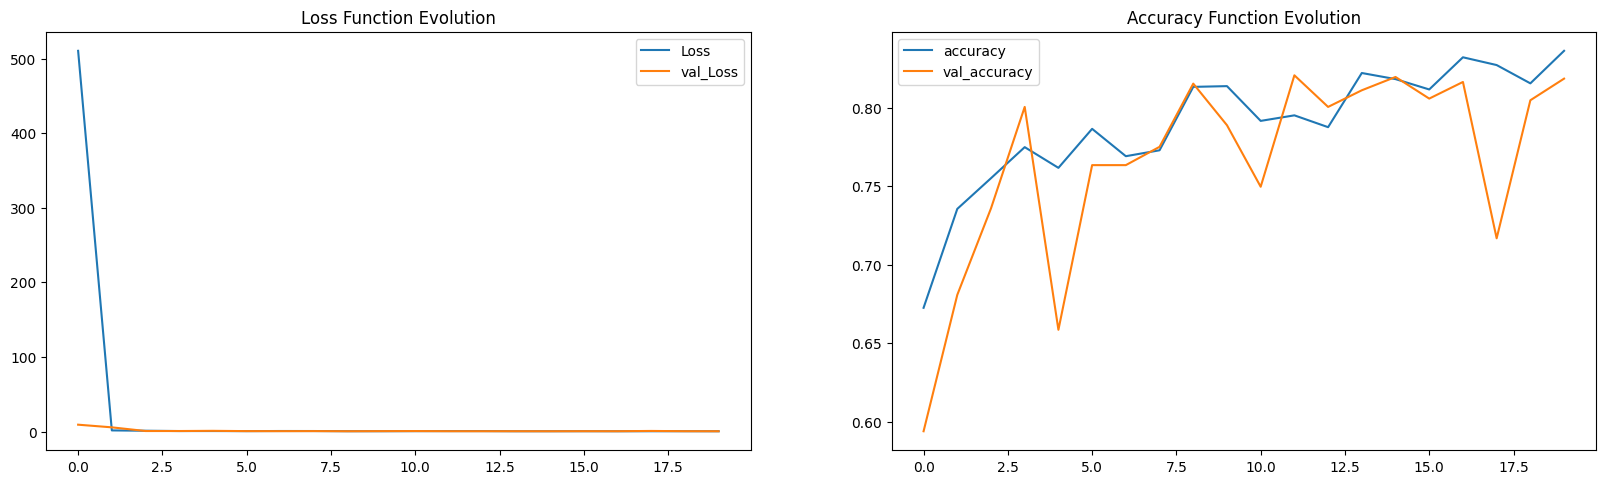

In [ ]:
plt.figure(figsize=(20,25))
plt.subplot(4,2,1)
plt.plot(history_proposed_model.history['loss'], label='Loss')
plt.plot(history_proposed_model.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.subplot(4,2,2)
plt.plot(history_proposed_model.history['accuracy'], label='accuracy')
plt.plot(history_proposed_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [ ]:
num_samples,height,width,ch= X.shape
X_reshaped=X.reshape((num_samples, height * width))
scaler =StandardScaler()
scaler.fit(X_reshaped)
X_normalized = scaler.transform(X_reshaped)
X_normalized_reshaped = X_normalized.reshape((-1,img_size, img_size,1))
y_one_hot =to_categorical(y, num_classes=len(categories))

X_train, X_test, y_train, y_test = train_test_split(X_normalized_reshaped, y_one_hot, test_size=0.05, random_state=2,shuffle=True,stratify=y)

proposed_model = tf.keras.Sequential([
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128),
    Dense(64),
    Dense(2),
    Activation('softmax')])

learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)
proposed_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_proposed_model=proposed_model.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.1 )

Epoch 1/20
133/133 [==============================] - 14s 65ms/step - loss: 976.2456 - accuracy: 0.6359 - val_loss: 5.0530 - val_accuracy: 0.7010
Epoch 2/20
133/133 [==============================] - 8s 62ms/step - loss: 1.2722 - accuracy: 0.7205 - val_loss: 0.6102 - val_accuracy: 0.7699
Epoch 3/20
133/133 [==============================] - 8s 64ms/step - loss: 0.5941 - accuracy: 0.7573 - val_loss: 0.6520 - val_accuracy: 0.7222
Epoch 4/20
133/133 [==============================] - 8s 63ms/step - loss: 0.6254 - accuracy: 0.7480 - val_loss: 0.5916 - val_accuracy: 0.7709
Epoch 5/20
133/133 [==============================] - 8s 63ms/step - loss: 0.5529 - accuracy: 0.7645 - val_loss: 0.6570 - val_accuracy: 0.7455
Epoch 6/20
133/133 [==============================] - 8s 64ms/step - loss: 0.5343 - accuracy: 0.7735 - val_loss: 0.5486 - val_accuracy: 0.7561
Epoch 7/20
133/133 [==============================] - 8s 63ms/step - loss: 0.5733 - accuracy: 0.7660 - val_loss: 0.5220 - val_accuracy: 0.7

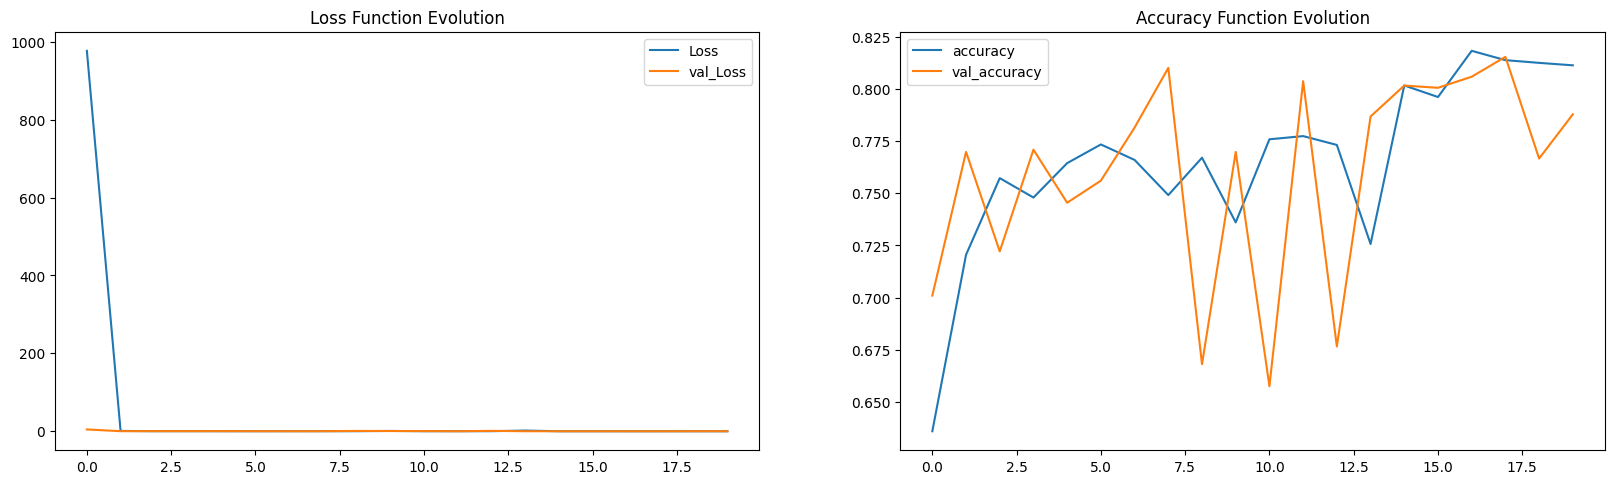

In [ ]:
plt.figure(figsize=(20,25))
plt.subplot(4,2, 1)
plt.plot(history_proposed_model.history['loss'], label='Loss')
plt.plot(history_proposed_model.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.subplot(4,2, 2)
plt.plot(history_proposed_model.history['accuracy'], label='accuracy')
plt.plot(history_proposed_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

AUC: 0.80


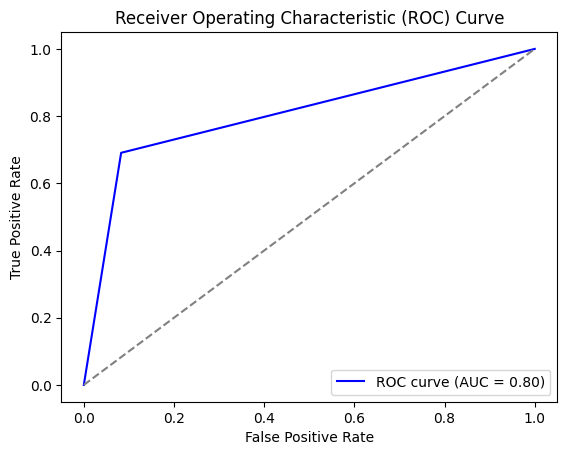

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
print('AUC: %.2f' % auc)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Results Comparison with several CNNs with different characteristics


**Case 1: train:50% test:30%**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized_reshaped, y_one_hot, test_size=0.3, random_state=2,shuffle=True,stratify=y)

case1 =   tf.keras.Sequential([
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], kernel_initializer=GlorotUniform(),padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3),padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128),
    Dense(64),
    Dense(2),
    Activation('softmax')])

learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)
case1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_case1=case1.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.4 ) # 40% of train = 20% of total

Epoch 1/20
66/66 [==============================] - 10s 109ms/step - loss: 1053.4576 - accuracy: 0.6168 - val_loss: 189.0224 - val_accuracy: 0.5264
Epoch 2/20
66/66 [==============================] - 5s 76ms/step - loss: 6.7414 - accuracy: 0.7099 - val_loss: 9.0553 - val_accuracy: 0.6456
Epoch 3/20
66/66 [==============================] - 5s 84ms/step - loss: 2.2374 - accuracy: 0.7324 - val_loss: 4.8935 - val_accuracy: 0.6578
Epoch 4/20
66/66 [==============================] - 5s 77ms/step - loss: 2.5053 - accuracy: 0.7336 - val_loss: 2.3302 - val_accuracy: 0.6635
Epoch 5/20
66/66 [==============================] - 5s 75ms/step - loss: 0.8898 - accuracy: 0.7478 - val_loss: 0.7975 - val_accuracy: 0.7503
Epoch 6/20
66/66 [==============================] - 5s 74ms/step - loss: 0.7809 - accuracy: 0.7540 - val_loss: 2.7254 - val_accuracy: 0.5358
Epoch 7/20
66/66 [==============================] - 5s 75ms/step - loss: 2.1296 - accuracy: 0.7118 - val_loss: 1.4165 - val_accuracy: 0.7294
Epoch 

In [40]:
y_true=np.argmax(y_test,axis=1)
y_pred = case1.predict([X_test])
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred)
print("Precision:", precision)
recall = recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = f1_score(y_true, y_pred)
print("F1 score:", f1)

94/94 [==============================] - 1s 10ms/step
[[1556  181]
 [ 641  600]]
Accuracy: 0.7239758226997985
Precision: 0.7682458386683739
Recall: 0.48348106365834004
F1 score: 0.5934718100890208


**Case2: Drop-Out**

In [20]:
case2 = tf.keras.Sequential([
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], kernel_initializer=GlorotUniform()),
    Dropout(0.2),
    BatchNormalization(),
    Conv2D(32, (3,3),padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3)),
    Dropout(0.2),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128),
    Dense(64),
    Dropout(0.2),
    Dense(2),
    Activation('softmax')])

optimizer = Adam(learning_rate=0.1)
case2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_case2=case2.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.1 )

Epoch 1/20
133/133 [==============================] - 21s 119ms/step - loss: 611.6499 - accuracy: 0.6321 - val_loss: 9.3612 - val_accuracy: 0.5854
Epoch 2/20
133/133 [==============================] - 14s 108ms/step - loss: 1.9642 - accuracy: 0.6747 - val_loss: 2.0348 - val_accuracy: 0.5864
Epoch 3/20
133/133 [==============================] - 14s 109ms/step - loss: 27.7461 - accuracy: 0.6741 - val_loss: 0.5227 - val_accuracy: 0.7805
Epoch 4/20
133/133 [==============================] - 15s 109ms/step - loss: 0.5053 - accuracy: 0.7764 - val_loss: 0.4886 - val_accuracy: 0.7773
Epoch 5/20
133/133 [==============================] - 15s 110ms/step - loss: 0.4912 - accuracy: 0.7880 - val_loss: 0.4781 - val_accuracy: 0.7762
Epoch 6/20
133/133 [==============================] - 15s 112ms/step - loss: 0.4913 - accuracy: 0.7824 - val_loss: 0.5083 - val_accuracy: 0.7614
Epoch 7/20
133/133 [==============================] - 15s 111ms/step - loss: 0.4833 - accuracy: 0.7847 - val_loss: 0.4769 - val

In [22]:
y_true=np.argmax(y_test,axis=1)
y_pred = case2.predict([X_test])
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(testt, y_pred)
print(conf_mat)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred)
print("Precision:", precision)
recall = recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = f1_score(y_true, y_pred)
print("F1 score:", f1)

16/16 [==============================] - 1s 29ms/step
[[260  30]
 [ 49 158]]
Accuracy: 0.8410462776659959
Precision: 0.8404255319148937
Recall: 0.7632850241545893
F1 score: 0.8000000000000002


In [28]:
from tensorflow.keras.initializers import RandomNormal

case3 = tf.keras.Sequential([
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], kernel_initializer=RandomNormal(mean=0.0, stddev=0.05)),
    Dropout(0.2),
    BatchNormalization(),
    Conv2D(32, (3,3),padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3)),
    Dropout(0.2),
    BatchNormalization(),
    Conv2D(32, (3,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128),
    Dense(64),
    Dropout(0.2),
    Dense(2),
    Activation('softmax')])

optimizer = Adam(learning_rate=0.1)
case3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_case3=case3.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.1 )

Epoch 1/20
133/133 [==============================] - 19s 112ms/step - loss: 767.3163 - accuracy: 0.6202 - val_loss: 1.1053 - val_accuracy: 0.7063
Epoch 2/20
133/133 [==============================] - 15s 110ms/step - loss: 0.7277 - accuracy: 0.6999 - val_loss: 0.7287 - val_accuracy: 0.7031
Epoch 3/20
133/133 [==============================] - 15s 109ms/step - loss: 0.7516 - accuracy: 0.6866 - val_loss: 0.5625 - val_accuracy: 0.7243
Epoch 4/20
133/133 [==============================] - 15s 110ms/step - loss: 1.0335 - accuracy: 0.6670 - val_loss: 1.1419 - val_accuracy: 0.5726
Epoch 5/20
133/133 [==============================] - 15s 111ms/step - loss: 0.6370 - accuracy: 0.6993 - val_loss: 0.5331 - val_accuracy: 0.7540
Epoch 6/20
133/133 [==============================] - 15s 110ms/step - loss: 0.5603 - accuracy: 0.7408 - val_loss: 0.6983 - val_accuracy: 0.6999
Epoch 7/20
133/133 [==============================] - 15s 110ms/step - loss: 0.6076 - accuracy: 0.7202 - val_loss: 0.6278 - val_

In [29]:
y_true=np.argmax(y_test,axis=1)
y_pred = case3.predict([X_test])
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(testt, y_pred)
print(conf_mat)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred)
print("Precision:", precision)
recall = recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = f1_score(y_true, y_pred)
print("F1 score:", f1)

16/16 [==============================] - 0s 12ms/step
[[201  89]
 [ 19 188]]
Accuracy: 0.7826961770623743
Precision: 0.6787003610108303
Recall: 0.9082125603864735
F1 score: 0.7768595041322314


**Case4.1: Test model 1 from the paper**

In [33]:
#CNN- Testing model 1
test1_model = Sequential()
test1_model.add(Conv2D(32,(3,3),input_shape=X_train.shape[1:],kernel_initializer=GlorotUniform() ))
test1_model.add(BatchNormalization())
test1_model.add(MaxPooling2D(pool_size=(2,2)))
test1_model.add(Conv2D(32,(3,3) ))
test1_model.add(BatchNormalization())
test1_model.add(MaxPooling2D(pool_size=(2,2)))
test1_model.add(Flatten())
test1_model.add(Dense(128))
test1_model.add(Dense(2))
test1_model.add(Activation('softmax'))
test1_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history_test1_model=test1_model.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.1 )

Epoch 1/20
133/133 [==============================] - 6s 32ms/step - loss: 2.8967 - accuracy: 0.7426 - val_loss: 1.0001 - val_accuracy: 0.6448
Epoch 2/20
133/133 [==============================] - 4s 28ms/step - loss: 0.6086 - accuracy: 0.8609 - val_loss: 0.8891 - val_accuracy: 0.6702
Epoch 3/20
133/133 [==============================] - 4s 28ms/step - loss: 0.2979 - accuracy: 0.9006 - val_loss: 0.4026 - val_accuracy: 0.8473
Epoch 4/20
133/133 [==============================] - 4s 30ms/step - loss: 0.1865 - accuracy: 0.9296 - val_loss: 0.3262 - val_accuracy: 0.8759
Epoch 5/20
133/133 [==============================] - 4s 28ms/step - loss: 0.1275 - accuracy: 0.9510 - val_loss: 0.3667 - val_accuracy: 0.8759
Epoch 6/20
133/133 [==============================] - 4s 28ms/step - loss: 0.1516 - accuracy: 0.9400 - val_loss: 0.5329 - val_accuracy: 0.8441
Epoch 7/20
133/133 [==============================] - 4s 28ms/step - loss: 0.1287 - accuracy: 0.9499 - val_loss: 1.1001 - val_accuracy: 0.7328

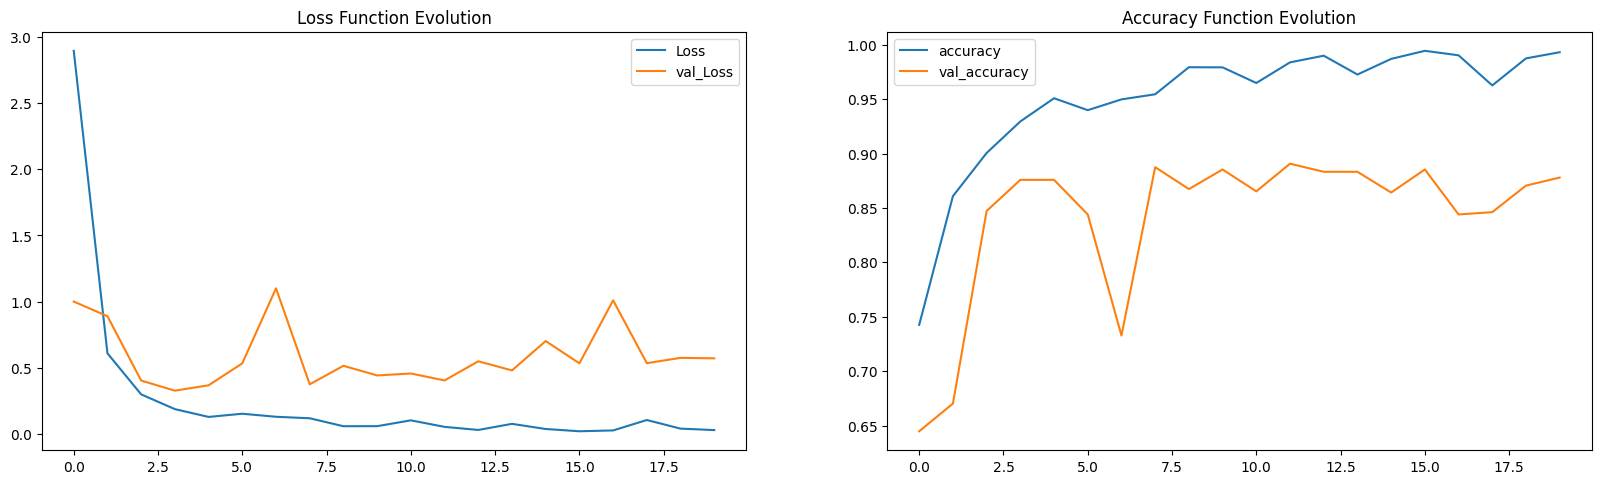

In [35]:
plt.figure(figsize=(20,25))
plt.subplot(4,2,1)
plt.plot(history_test1_model.history['loss'], label='Loss')
plt.plot(history_test1_model.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.subplot(4,2,2)
plt.plot(history_test1_model.history['accuracy'], label='accuracy')
plt.plot(history_test1_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [34]:
y_true=np.argmax(y_test,axis=1)
y_pred = test1_model.predict([X_test])
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(testt, y_pred)
print(conf_mat)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred)
print("Precision:", precision)
recall = recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = f1_score(y_true, y_pred)
print("F1 score:", f1)

16/16 [==============================] - 0s 12ms/step
[[253  37]
 [ 19 188]]
Accuracy: 0.8873239436619719
Precision: 0.8355555555555556
Recall: 0.9082125603864735
F1 score: 0.8703703703703705


**Case4.2: Test model 2 from the paper**

In [32]:
#CNN- Testing model 2
test2_model = Sequential()
test2_model.add(Conv2D(32,(3,3),input_shape=X_train.shape[1:],kernel_initializer=GlorotUniform() ))
test2_model.add(Conv2D(32,(3,3),kernel_initializer=GlorotUniform() ))
test2_model.add(MaxPooling2D(pool_size=(2,2)))
test2_model.add(Flatten())
test2_model.add(Dense(128))
test2_model.add(Dense(64))
test2_model.add(Dense(2))
test2_model.add(Activation('softmax'))
test2_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history_test2_model=test2_model.fit(X_train,y_train,batch_size=64, epochs=20,validation_split=0.1 )

Epoch 1/20
133/133 [==============================] - 8s 46ms/step - loss: 0.9367 - accuracy: 0.7570 - val_loss: 0.3995 - val_accuracy: 0.8346
Epoch 2/20
133/133 [==============================] - 6s 42ms/step - loss: 0.3208 - accuracy: 0.8667 - val_loss: 0.3729 - val_accuracy: 0.8558
Epoch 3/20
133/133 [==============================] - 6s 43ms/step - loss: 0.2292 - accuracy: 0.9095 - val_loss: 0.3811 - val_accuracy: 0.8505
Epoch 4/20
133/133 [==============================] - 6s 42ms/step - loss: 0.1614 - accuracy: 0.9404 - val_loss: 0.4198 - val_accuracy: 0.8484
Epoch 5/20
133/133 [==============================] - 6s 43ms/step - loss: 0.1052 - accuracy: 0.9616 - val_loss: 0.4481 - val_accuracy: 0.8409
Epoch 6/20
133/133 [==============================] - 6s 43ms/step - loss: 0.0963 - accuracy: 0.9653 - val_loss: 0.5487 - val_accuracy: 0.8505
Epoch 7/20
133/133 [==============================] - 6s 43ms/step - loss: 0.0773 - accuracy: 0.9740 - val_loss: 0.6110 - val_accuracy: 0.8324

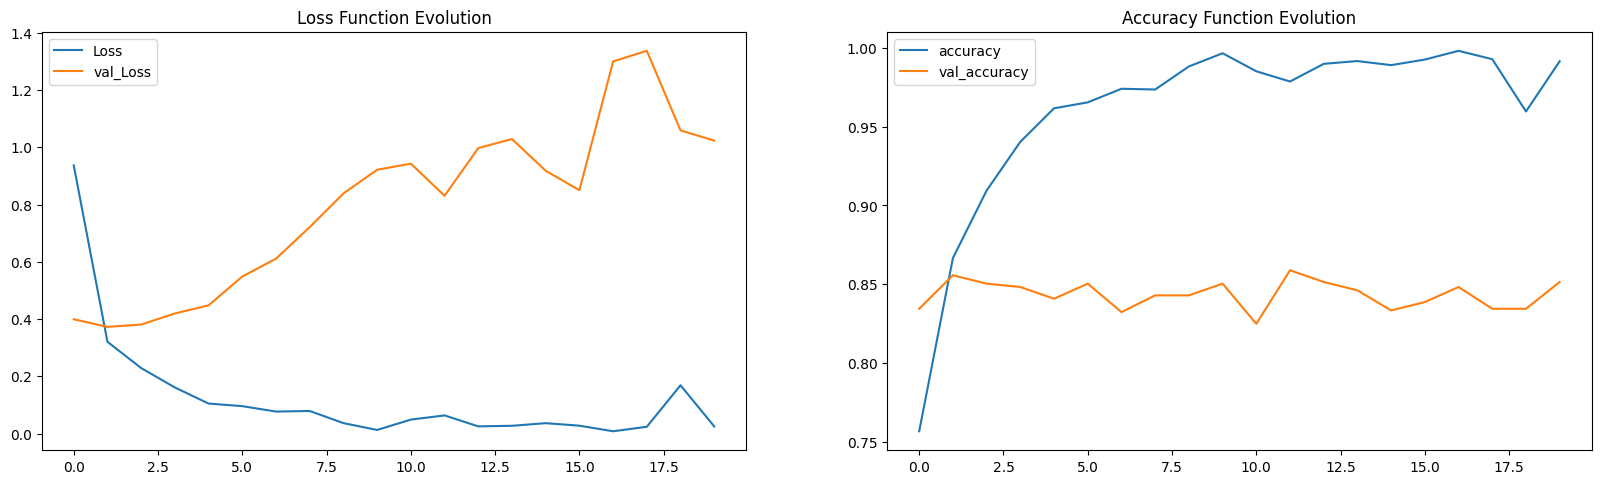

In [37]:
plt.figure(figsize=(20,25))
plt.subplot(4,2,1)
plt.plot(history_test2_model.history['loss'], label='Loss')
plt.plot(history_test2_model.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()
plt.subplot(4,2,2)
plt.plot(history_test2_model.history['accuracy'], label='accuracy')
plt.plot(history_test2_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [36]:
y_true=np.argmax(y_test,axis=1)
y_pred = test2_model.predict([X_test])
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(testt, y_pred)
print(conf_mat)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred)
print("Precision:", precision)
recall = recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = f1_score(y_true, y_pred)
print("F1 score:", f1)

16/16 [==============================] - 0s 8ms/step
[[271  19]
 [ 44 163]]
Accuracy: 0.8732394366197183
Precision: 0.8956043956043956
Recall: 0.7874396135265701
F1 score: 0.8380462724935733
